In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [35]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')

In [36]:
test.drop('out_pressure',axis=1, inplace=True)
train.drop('out_pressure',axis=1, inplace=True)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [38]:
te = test.drop(['type'], axis=1)
tr = train.drop(['type'], axis= 1)

In [39]:
ss = StandardScaler()

In [40]:
ss.fit(tr)

StandardScaler()

In [41]:
train_sc = ss.transform(tr)

In [42]:
test_sc = ss.fit_transform(te)

In [43]:
epsilon = 0.3
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(train_sc)

In [44]:
dbscan_test = DBSCAN(eps=epsilon, min_samples=min_samples).fit(test_sc)

In [45]:
labels = dbscan.fit_predict(train_sc)

In [46]:
train_sc = pd.DataFrame(train_sc)

In [47]:
train_sc['label'] = labels

In [48]:
train_sc[train_sc['label'] != -1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462],
           dtype='int64', length=2447)

In [49]:
train_sc = train_sc.loc[train_sc[train_sc['label'] != -1].index].drop('label', axis=1)

In [50]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

In [51]:
model = OneClassSVM()

In [69]:
param_grid = {
    'kernel': ['rbf','poly','linear', 'sigmoid'],
    'nu': [0.01, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma' : [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

In [53]:
param_grid = {
    'kernel': ['rbf','poly','linear', 'sigmoid'],
    'nu': [0.01, 0.5, 0.1, 0.2, 0.3, 0.4],
    'gamma' : ['scale', 'auto']
}

In [70]:
grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=10)

In [71]:
grid_search.fit(train_sc)

GridSearchCV(cv=10, estimator=OneClassSVM(),
             param_grid={'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                         'nu': [0.01, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                0.8, 0.9, 1]},
             scoring='f1_weighted')

In [72]:
best_params = grid_search.best_params_
print(f'Best Parmas:{best_params}')

Best Parmas:{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.01}


In [73]:
svm_fit = OneClassSVM(**best_params)
svm_fit.fit(train_sc)

OneClassSVM(gamma=0.001, nu=0.01)

In [74]:
prediction = svm_fit.predict(test_sc)

In [75]:
prediction

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [76]:
prediction = pd.DataFrame(prediction).replace(1,0).replace(-1,1)

In [77]:
prediction.columns = ['label']

In [78]:
score = svm_fit.score_samples(test_sc)

In [79]:
threshold = np.quantile(score,0.05)

In [80]:
index = np.where(score < threshold)

In [81]:
prediction['label'] = 0

In [82]:
prediction.loc[index[0], 'label'] = 1

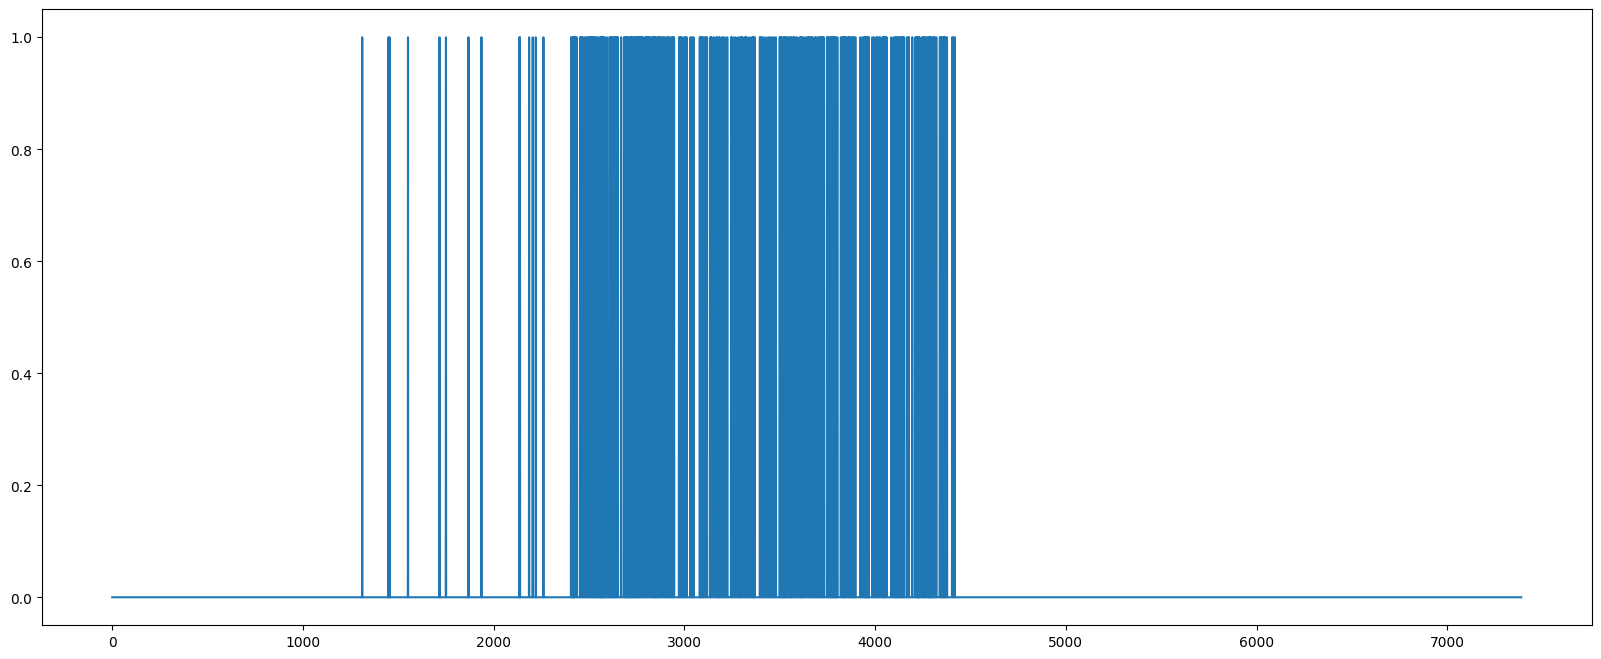

In [83]:
plt.figure(figsize= (20,8))
plt.plot(prediction)

In [84]:
prediction.label.value_counts()

0    7019
1     370
Name: label, dtype: int64

prediction.to_csv('C:/Users/User/Desktop/svdd.csv', index = False)